In [1]:
import cv2
import numpy as np
import os
from PIL import Image as PILImage, ImageOps

from skimage.feature import hessian_matrix, hessian_matrix_eigvals
%matplotlib inline 
import matplotlib.pyplot as plt

from IPython.display import Image, display, Markdown as md
import requests

Your image:


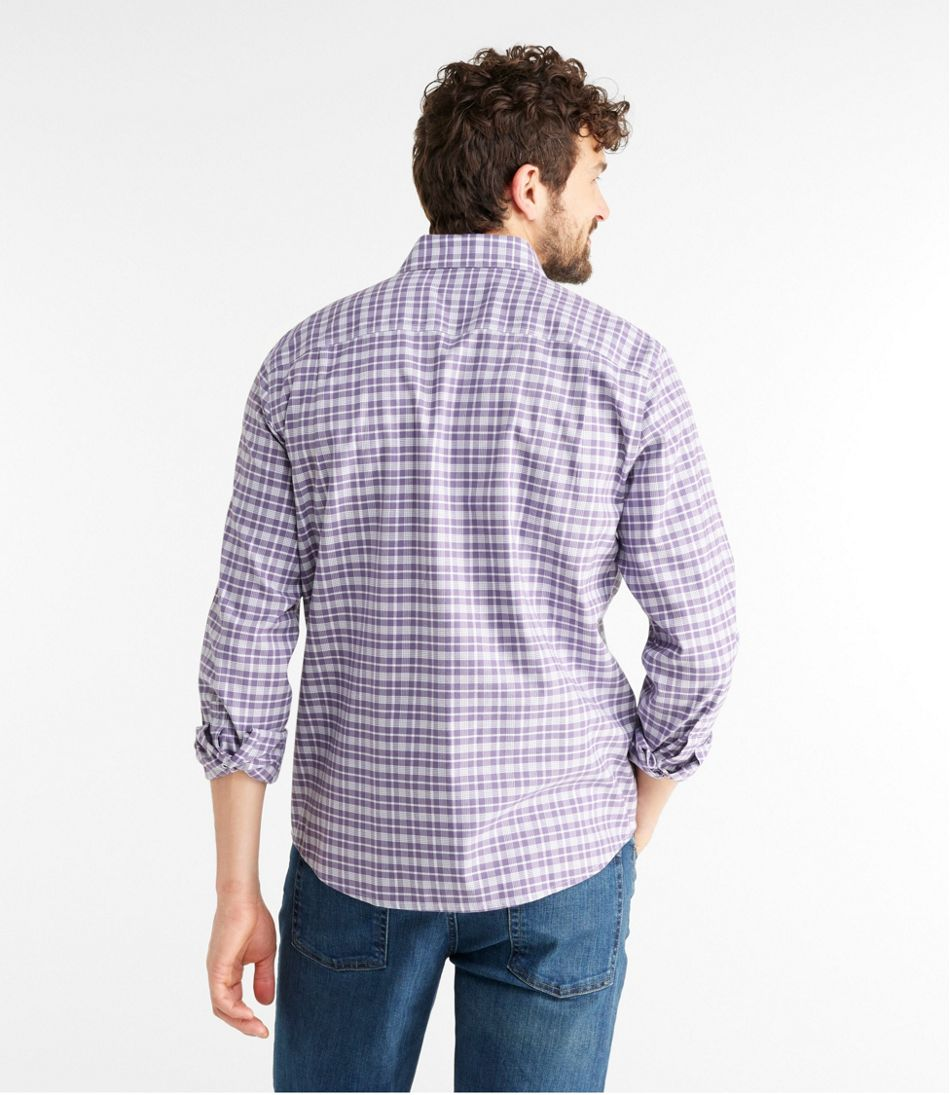

In [2]:
source_path = "sources/people_shirt.jpg"

# for imageName in listOfImageNames:
print("Your image:")
display(Image(filename=source_path))

api_key = "bbbc910759e059eee68b1c61f659c2ad82f9aa3a0137210b0981ce46da28778cb24ed6c236abb8d4daa8421c9090b838"

test = 2 # if colored pic or complex choose 2, if simple(means got a subject) choose 1

# Segment Objects with api

In [3]:
if test==1:
    import io 
    import requests
    with open(source_path, 'rb') as image_file_object:
        r = requests.post('https://clipdrop-api.co/remove-background/v1',
        files = {
            'image_file': ('image.jpg', image_file_object, 'image/jpeg'),
            },
        headers = { 'x-api-key': api_key}
        )
        if (r.ok):
            # r.content contains the bytes of the returned image
            print("success")
            # r.content contains the bytes of the returned image
            print("Extracted Foreground:")
            # segmented_object = r.content
            segmented_object = r.content
            display(Image(data=segmented_object))
            
            segmented_object = PILImage.open(io.BytesIO(segmented_object))

            width, height = segmented_object.size
            edge_mask = np.asarray(segmented_object)

            
            def dilate(img, gaussian_sigma):
                blurred_img = cv2.GaussianBlur(img, (gaussian_sigma, gaussian_sigma), 0)
                (threshold_value, new_mask) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY)
                print("threshold_value",threshold_value)
                return new_mask

            guassian_sigma = 11 
            new_edge_mask_img = dilate(edge_mask, guassian_sigma)
            new_edge_mask_image = PILImage.fromarray(np.uint8(new_edge_mask_img))
            background = PILImage.new('RGBA', (width, height), (0, 0, 0, 1))
            background.paste(new_edge_mask_image, (0, 0), new_edge_mask_image)
            # new_edge_mask= np.asarray(background)
            print("dilated foreground mask:")
            display(background)

        else:
            print("failure",r.json())
            r.raise_for_status()

# Segment Objects with brain

dilated foreground mask:


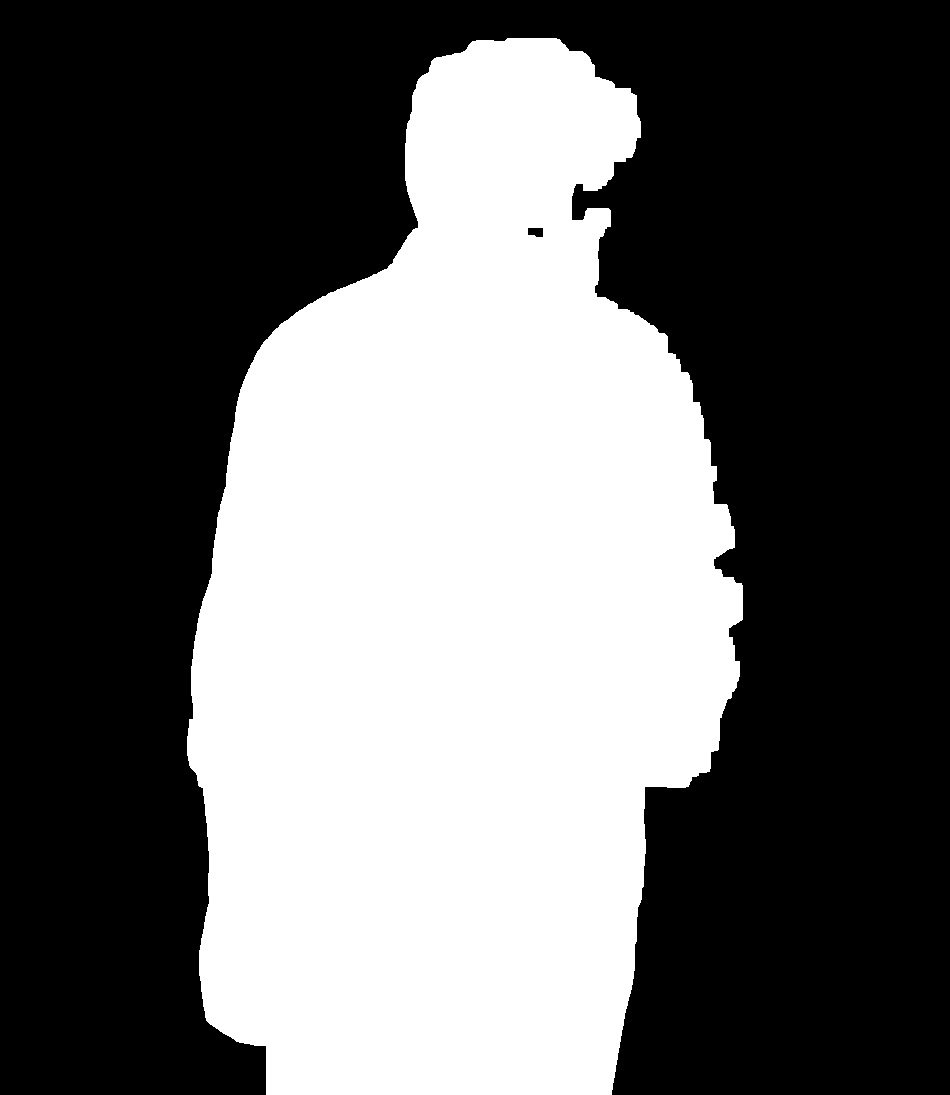

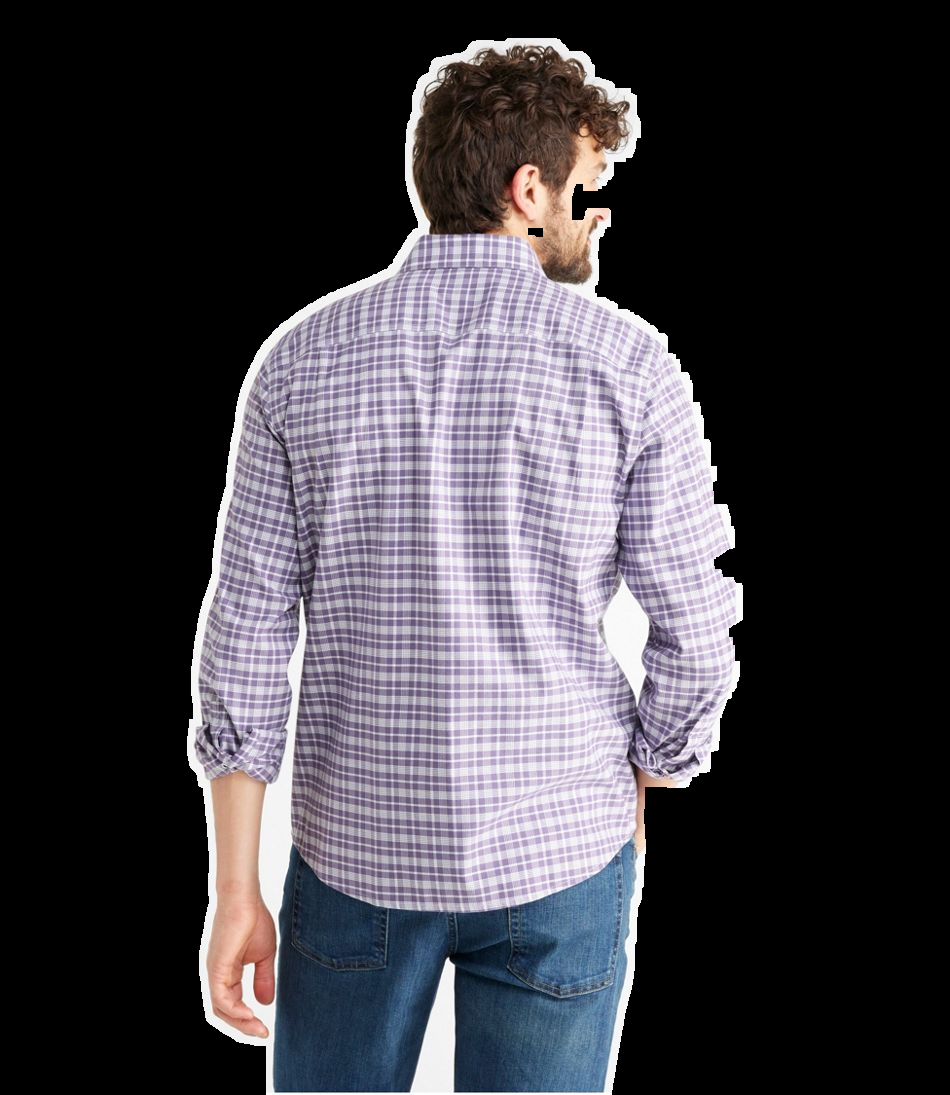

Segment objects:


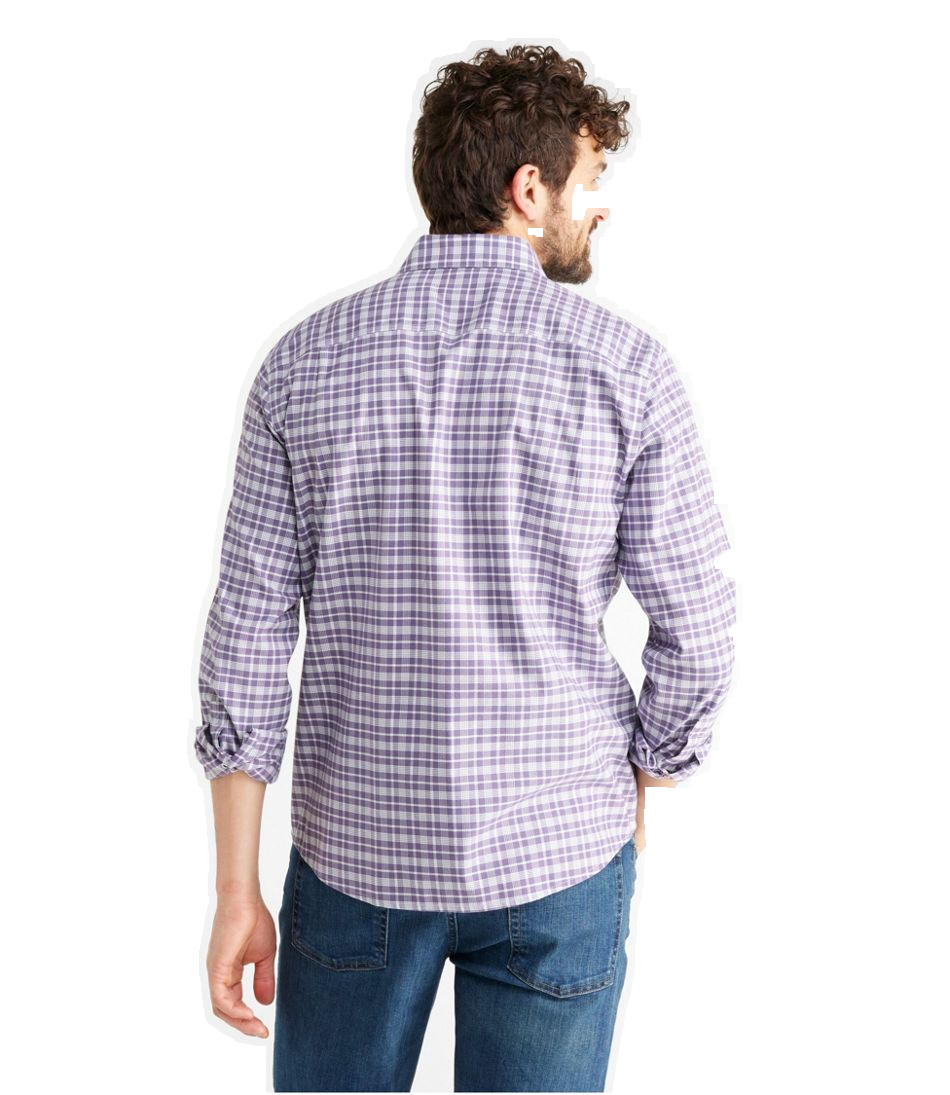

In [4]:
if test==2:

    #== Parameters           
    BLUR = 15
    CANNY_THRESH_1 = 100
    CANNY_THRESH_2 = 255
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format

    # source = 'sources/img.jpg'

    #-- Read image
    img = cv2.imread(source_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #-- Edge detection 
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area 
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))

    #-- Smooth mask, then blur it
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    (threshold_value, mask) = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    # def dilate(img, gaussian_sigma):
    #     blurred_img = cv2.GaussianBlur(img, (gaussian_sigma, gaussian_sigma), 0)
    #     print("threshold_value",threshold_value)
    #     return new_mask

    # width, height = mask_stack.size
    # guassian_sigma = 11 #! change sigma to generate fake results
    # new_edge_mask_img = dilate(mask_stack, guassian_sigma)
    # new_edge_mask_image = PILImage.fromarray(np.uint8(new_edge_mask_img))
    # background = PILImage.new('RGBA', (width, height), (0, 0, 0, 1))
    # background.paste(new_edge_mask_image, (0, 0), new_edge_mask_image)
    # new_edge_mask= np.asarray(background)

    background = PILImage.fromarray(np.uint8(mask_stack))
    print("dilated foreground mask:")
    display(background)
    # display(PILImage.fromarray(np.uint8(masked)))

    #-- Blend masked img into MASK_COLOR background
    mask_stack  = mask_stack.astype('float32') / 255.0         
    img         = img.astype('float32') / 255.0    
    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR)  
    masked = (masked * 255).astype('uint8')
    masked = masked[:,:,::-1]   
    display(PILImage.fromarray(np.uint8(masked)))
                

    segmented_object = PILImage.fromarray(np.uint8(masked)).convert("RGBA")
    datas = segmented_object.getdata()

    newData = []
    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 0:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    segmented_object.putdata(newData)
    print("Segment objects:")
    display(segmented_object)

# Extract background

success
Extracted background:


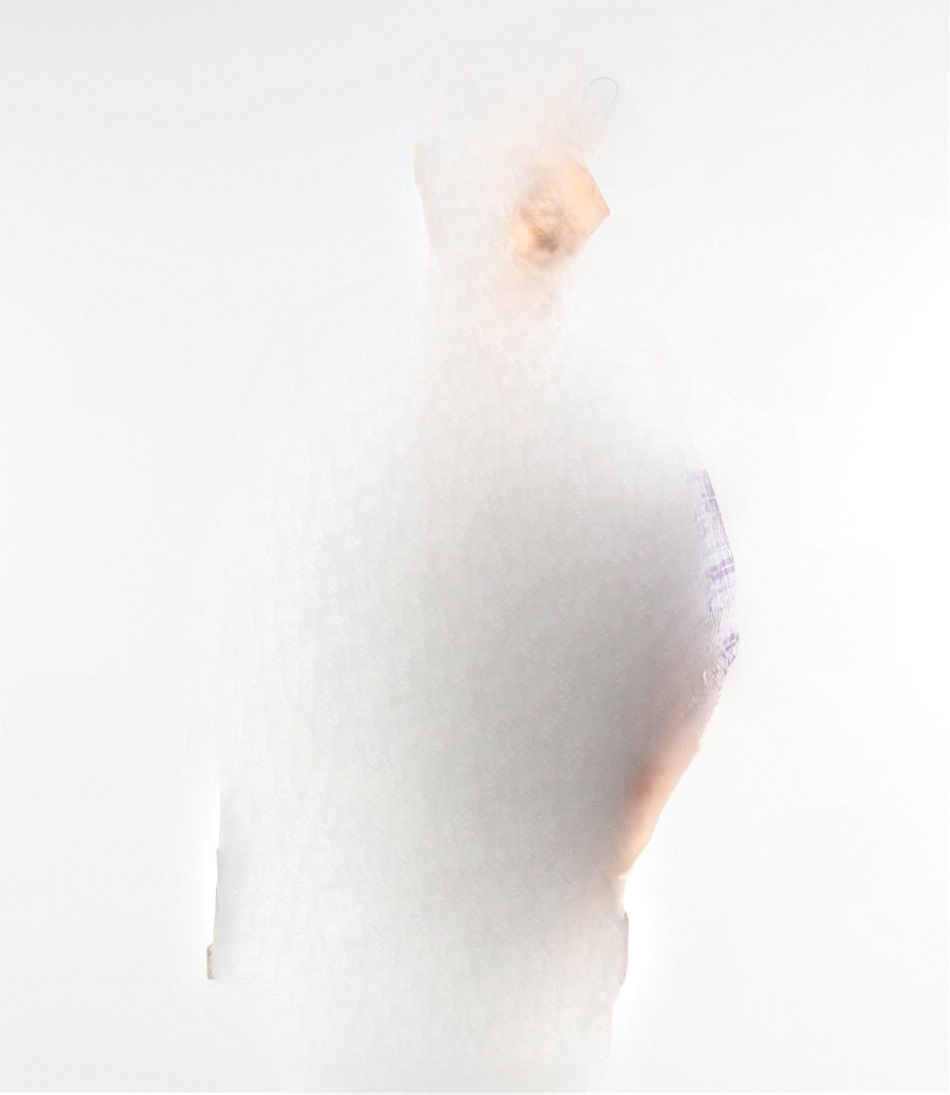

In [5]:
from io import BytesIO

buf = BytesIO()
background.save(buf, format='PNG')
mask_file_object = buf.getvalue()

with open(source_path, 'rb') as image_file_object:
    # print("sending request",image_file_object, mask_file_object)
    r = requests.post('https://clipdrop-api.co/cleanup/v1',
    files = {
        'image_file': ('image.jpg', image_file_object, 'image/jpeg'),
        'mask_file': ('mask.png', mask_file_object, 'image/png')
        },
    headers = { 'x-api-key': api_key}
    )

    if (r.ok):
        print("success")
        # r.content contains the bytes of the returned image
        # with open(f"{cwd}\clean\clean_{source_path[8:-4]}.jpg", 'wb') as f:
        #     f.write(r.content)
        print("Extracted background:")
        extract_background = r.content
        display(Image(data=extract_background))
        
        extract_background = PILImage.open(BytesIO(extract_background))
        extract_background_grayscale = np.asarray(extract_background.convert('L'))
        
    else:
        print("failure",r.json())
        r.raise_for_status()

# Detect Ridges

C:\Users\Andrew\AppData\Local\Temp/ipykernel_12820/2008884680.py:4: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  hessian = hessian_matrix(gray, sigma)


ridge detection mask:


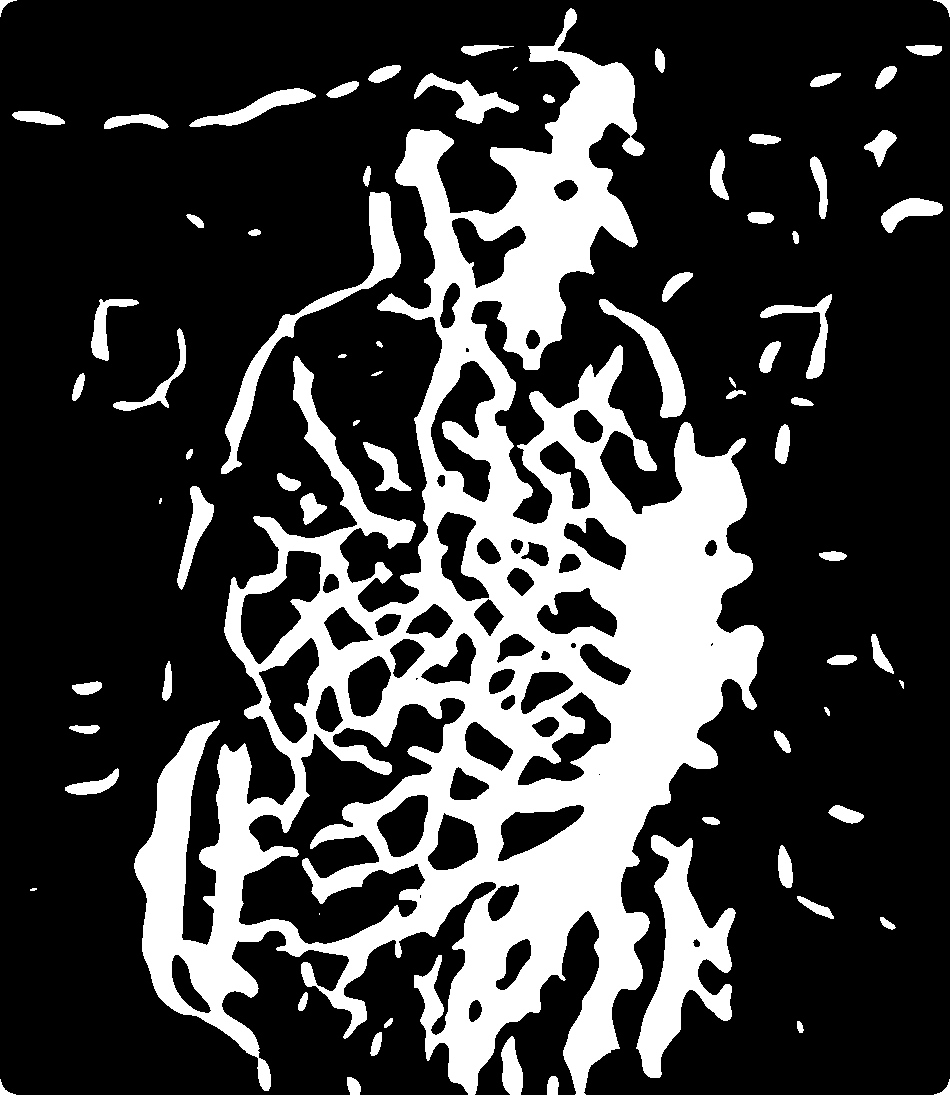

In [6]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=2.5):
    hessian = hessian_matrix(gray, sigma)
    i1, i2 = hessian_matrix_eigvals(hessian)
    # print(i1.shape, i2.shape)
    return i1, i2

# original = "sources/foil.jpg"
# source_path = f"clean/clean_{original[8:-4]}.jpg"
ridge_detection_sigma = 11.0 #! change sigma to generate fake results
# cwd = os.getcwd()

# source_image = cv2.imread(source_path,cv2.IMREAD_GRAYSCALE|cv2.IMREAD_IGNORE_ORIENTATION)
# extract_background_grayscale2 = PILImage.fromarray(np.uint8(extract_background_grayscale))
# display(extract_background_grayscale2)
i1, i2 = detect_ridges(extract_background_grayscale, ridge_detection_sigma)

# # Apply a threshold to get a binary image
thresh = np.mean(i1)
i1_binary = (i1 > thresh).astype(np.uint8)

thresh = np.mean(i2)
i2_binary = (i2 > thresh).astype(np.uint8)

# # Normalize the binary images for display
i1_normalized = cv2.normalize(i1_binary, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
i2_normalized = cv2.normalize(i2_binary, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)



# Scale the images back to the range [0, 255]
i1_scaled = (i1_normalized * 255).astype(np.uint8)
i2_scaled = (i2_normalized * 255).astype(np.uint8)
ridge_mask = i1_scaled
ridge_mask = PILImage.fromarray(ridge_mask)

print("ridge detection mask:")
display(ridge_mask)

# Remove creases in background

In [7]:
buf = BytesIO()
extract_background.save(buf, format='JPEG')
image_file_object = buf.getvalue()

buf = BytesIO()
ridge_mask.save(buf, format='PNG')
mask_file_object = buf.getvalue()

# print("sending request",image_file_object,mask_file_object)
r = requests.post('https://clipdrop-api.co/cleanup/v1',
files = {
    'image_file': ('image.jpg', image_file_object, 'image/jpeg'),
    'mask_file': ('mask.png', mask_file_object, 'image/png')
    },
headers = { 'x-api-key': api_key}
)

if (r.ok):
    print("success")
    # r.content contains the bytes of the returned image
    # with open(f"{cwd}\clean\clean_curves\clean_curves_{original[8:-4]}.jpg", 'wb') as f:
    #     f.write(r.content)
    
    print("Removed-crease background:")
    removed_crease_background = r.content
    display(Image(data=removed_crease_background))
    
    removed_crease_background = PILImage.open(BytesIO(removed_crease_background))
    # removed_crease_background_grayscale = np.asarray(removed_crease_background.convert('L'))
    
else:
    print("failure",r.json())
    r.raise_for_status()

# Result

size:  (950, 1095)   (950, 1095)


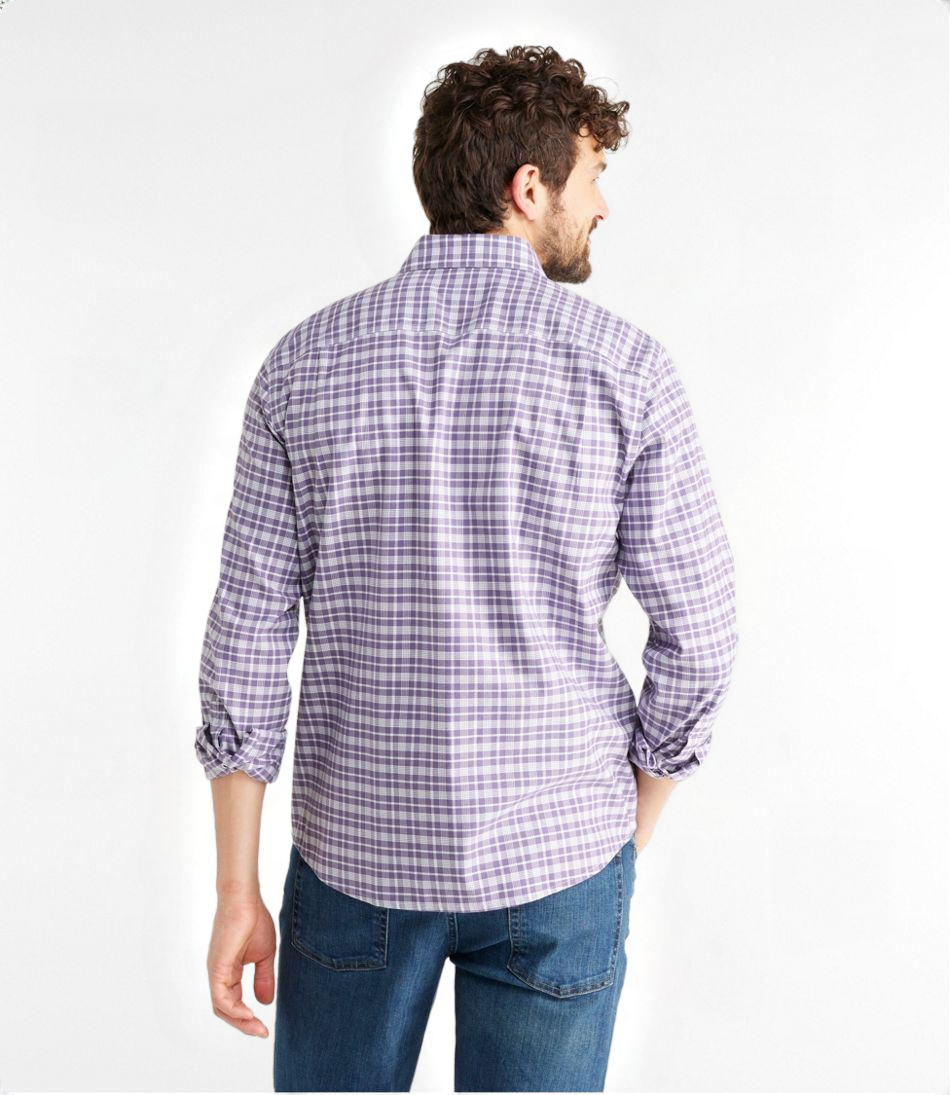

In [ ]:
print("size: ",removed_crease_background.size, " ", segmented_object.size)

# # Display the results
removed_crease_background.paste(segmented_object, (0, 0), segmented_object)
# background.save(result_path)
display(removed_crease_background)